# Survival SVM

In [ ]:
pip install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 41.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import set_config
from sklearn.model_selection import RepeatedKFold, GridSearchCV

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

set_config(display="text")  # displays text representation of estimators
sns.set_style("whitegrid")

In [ ]:
# load dataset
data_x, y = load_veterans_lung_cancer()
x = encode_categorical(data_x)

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# rank ratio = 0
# As a regression problem: the model learns to directly predict the (log) survival time.
estimator = FastSurvivalSVM(rank_ratio=0.0, max_iter=1000, tol=1e-5, random_state=42)

In [ ]:
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Status"], y["Survival_in_days"], -prediction)
    return result[0]

In [ ]:
param_grid = {"alpha": 2.0 ** np.arange(-12, 13, 2)}

# 5 repetitions of 5-fold cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
gcv = GridSearchCV(estimator, param_grid, scoring=score_survival_model, n_jobs=-1, refit=False, cv=cv)

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
gcv = gcv.fit(x_train, y_train)

In [ ]:
print("Best parameters:", gcv.best_params_)
print("Best C-index:", round(gcv.best_score_, 3))

Best parameters: {'alpha': 4.0}
Best C-index: 0.723


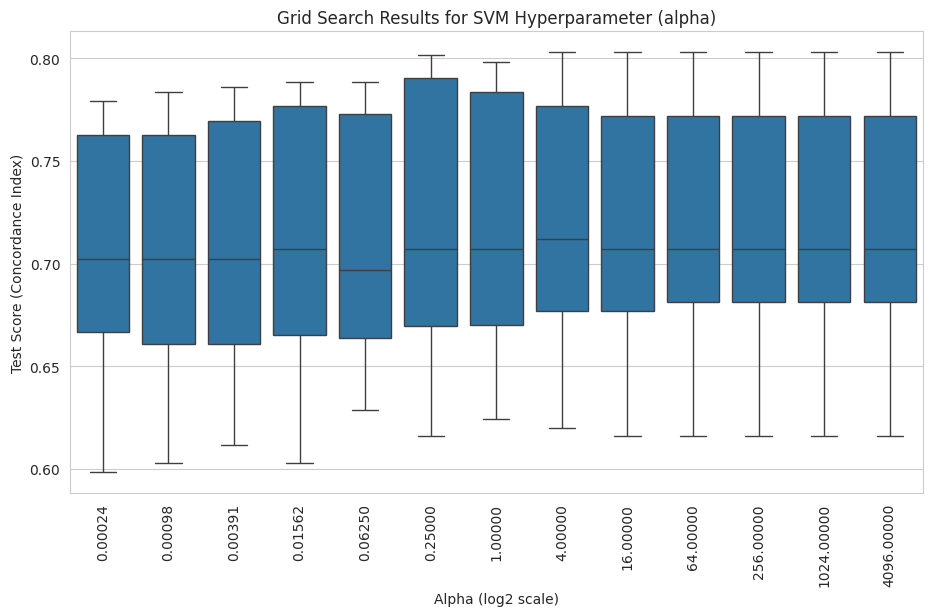

In [ ]:
def plot_performance(gcv):
    cv_results = gcv.cv_results_
    param_values = cv_results['param_alpha'].data.astype(float)
    test_scores = cv_results['mean_test_score']
    n_splits = len(cv_results['split0_test_score'])  # Accessing the number of splits

    cv_scores = {"alpha": [], "test_score": [], "split": []}
    order = []

    for i, param_value in enumerate(param_values):
        name = f'{param_value:.5f}'
        order.append(name)
        for j in range(n_splits):
            vs = cv_results[f"split{j}_test_score"][i]
            cv_scores["alpha"].append(name)
            cv_scores["test_score"].append(vs)
            cv_scores["split"].append(j)

    df = pd.DataFrame.from_dict(cv_scores)
    _, ax = plt.subplots(figsize=(11, 6))
    sns.boxplot(x="alpha", y="test_score", data=df, order=order, ax=ax)
    _, xtext = plt.xticks()
    for t in xtext:
        t.set_rotation("vertical")

    plt.title('Grid Search Results for SVM Hyperparameter (alpha)')
    plt.xlabel('Alpha (log2 scale)')
    plt.ylabel('Test Score (Concordance Index)')
    plt.show()

plot_performance(gcv)

In [ ]:
#def plot_performance(gcv):
#    n_splits = gcv.cv.get_n_splits()
#    cv_results = pd.DataFrame(gcv.cv_results_)
#    cv_results = cv_results.rename(columns=lambda x: x.replace("param_", ""))

#    plt.figure(figsize=(6, 3))
#    sns.stripplot(x="alpha", y="mean_test_score", data=cv_results, jitter=True, dodge=True)
#    plt.title("Cross-validated Performance vs. Alpha")
#    plt.xlabel("Alpha")
#    plt.ylabel("Mean Evaluation Score")
#    plt.xticks(rotation=45)
#    plt.show()

#plot_performance(gcv)

In [ ]:
estimator.set_params(**gcv.best_params_)
estimator.fit(x_train, y_train)

FastSurvivalSVM(alpha=4.0, max_iter=1000, optimizer='avltree', random_state=42,
                rank_ratio=0.0, tol=1e-05)

In [ ]:
train_pred = estimator.predict(x_train)

# Evaluate the model on the train set
train_cindex = concordance_index_censored(
    y_train["Status"],
    y_train["Survival_in_days"],
    -train_pred)           # flip sign to obtain risk scores
print("C-index on test set:", round(train_cindex[0], 3))


C-index on test set: 0.752


In [ ]:
test_pred = estimator.predict(x_test)
#print(np.round(test_pred, 3))
#print(y_test)

# Evaluate the model on the test set
test_cindex = concordance_index_censored(
    y_test["Status"],
    y_test["Survival_in_days"],
    -test_pred)           # flip sign to obtain risk scores
print("C-index on test set:", round(test_cindex[0], 3))


C-index on test set: 0.684


In [ ]:
# reference estimator (regression) and result

ref_estimator = FastSurvivalSVM(rank_ratio=0.0, max_iter=1000, tol=1e-5, random_state=42)
ref_estimator.fit(x_train, y_train)

cindex = concordance_index_censored(
    y_train["Status"],
    y_train["Survival_in_days"],
    -ref_estimator.predict(x_train),  # flip sign to obtain risk scores
)
print("C-index (train):", round(cindex[0], 3))

cindex = concordance_index_censored(
    y_test["Status"],
    y_test["Survival_in_days"],
    -ref_estimator.predict(x_test),  # flip sign to obtain risk scores
)
print("C-index (test):", round(cindex[0], 3))

C-index (train): 0.749
C-index (test): 0.687


In [ ]:
pred = ref_estimator.predict(x_test.iloc[:2])
print(np.round(pred, 3))

[ 3.643 35.007]
